In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastbook import *
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


path = Path('data/student_classification')
sns.set_style('whitegrid')
sns.set_context('paper')

### Dataset opening and basic examination

In [67]:
math_df = pd.read_csv(path/'student-mat.csv', delimiter=';')
port_df = pd.read_csv(path/'student-por.csv', delimiter=';')
math_df.shape,port_df.shape

((395, 33), (649, 33))

In [68]:
math_df.columns, port_df.columns

(Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
        'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
        'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
       dtype='object'),
 Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
        'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
        'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
       dtype='object'))

In [69]:
# note that columns in both datasets are the same
assert math_df.columns.all() == port_df.columns.all()

In [70]:
full_df = (pd.merge(math_df, port_df, on=["school","sex","age",
                             "address","famsize","Pstatus",
                             "Medu","Fedu","Mjob",
                             "Fjob","reason","nursery","internet"],
                   suffixes=('_m', '_p'))
          )
full_df.shape

(382, 53)

In [71]:
full_df.to_csv(path/'full_df.csv')

In [72]:
full_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian_m', 'traveltime_m', 'studytime_m',
       'failures_m', 'schoolsup_m', 'famsup_m', 'paid_m', 'activities_m',
       'nursery', 'higher_m', 'internet', 'romantic_m', 'famrel_m',
       'freetime_m', 'goout_m', 'Dalc_m', 'Walc_m', 'health_m', 'absences_m',
       'G1_m', 'G2_m', 'G3_m', 'guardian_p', 'traveltime_p', 'studytime_p',
       'failures_p', 'schoolsup_p', 'famsup_p', 'paid_p', 'activities_p',
       'higher_p', 'romantic_p', 'famrel_p', 'freetime_p', 'goout_p', 'Dalc_p',
       'Walc_p', 'health_p', 'absences_p', 'G1_p', 'G2_p', 'G3_p'],
      dtype='object')

In [73]:
# locating size of divergence from same student in a category
full_df.loc[full_df['freetime_m']==full_df['freetime_p']].shape

(371, 53)

### EDA

<ipython-input-74-5af6f818da00>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  math_df.hist(ax=ax,)


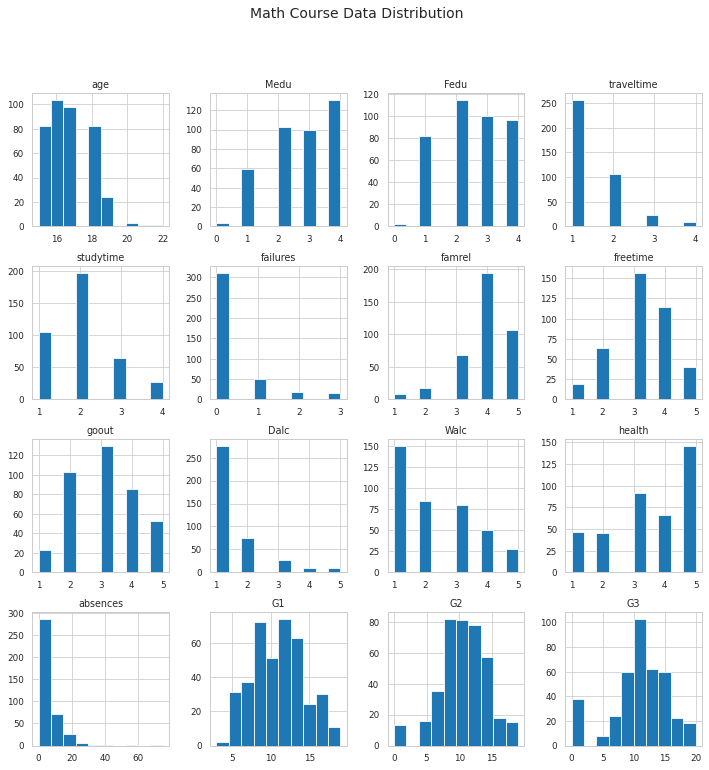

In [74]:
# looking at data distribution
fig, ax = plt.subplots(figsize=(12, 12))
math_df.hist(ax=ax,)
fig.suptitle('Math Course Data Distribution',size=14);

<ipython-input-66-1a6b6f2d0ce6>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  port_df.hist(ax=ax)


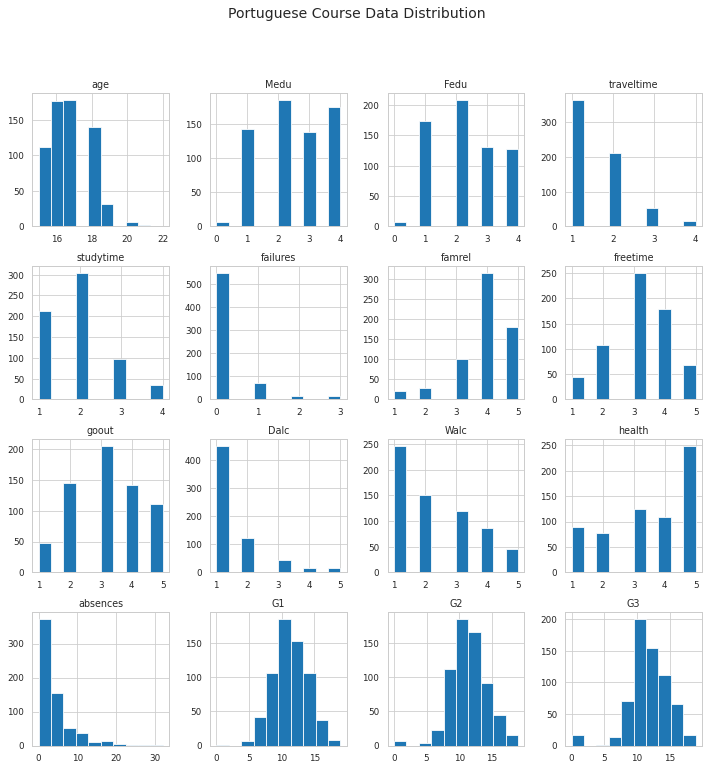

In [66]:
# looking at data distribution
fig, ax = plt.subplots(figsize=(12, 12))
port_df.hist(ax=ax)
fig.suptitle('Portuguese Course Data Distribution',size=14);

Text(0.5, 1.0, 'Grade Density')

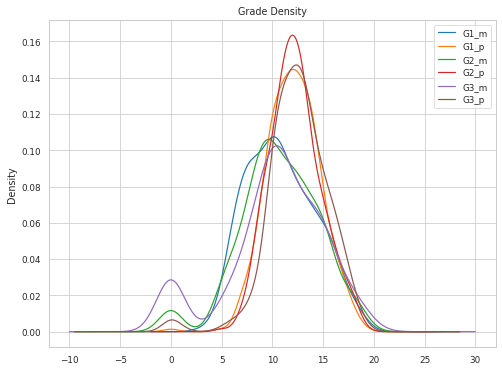

In [6]:
sns.set_style('whitegrid')
sns.set_context('paper')
# looking at grade comparision between same student
grade_cols = ['G1_m','G1_p','G2_m',
              'G2_p','G3_m','G3_p']
fig,ax = plt.subplots(figsize=(8,6))
full_df[grade_cols].plot.kde(ax=ax)
ax.set_title('Grade Density')

In [7]:
# basic description of the grades
full_df[grade_cols].describe()

,G1_m,G1_p,G2_m,G2_p,G3_m,G3_p
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,10.861257,12.112565,10.712042,12.238220,10.387435,12.515707
std,3.349167,2.556531,3.832560,2.468341,4.687242,2.945438
min,3.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,8.000000,10.000000,8.250000,11.000000,8.000000,11.000000
50%,10.500000,12.000000,11.000000,12.000000,11.000000,13.000000
75%,13.000000,14.000000,13.000000,14.000000,14.000000,14.000000
max,19.000000,19.000000,19.000000,19.000000,20.000000,19.000000


In [8]:
corr_matrix = full_df.drop(columns=grade_cols).corr()

<AxesSubplot:>

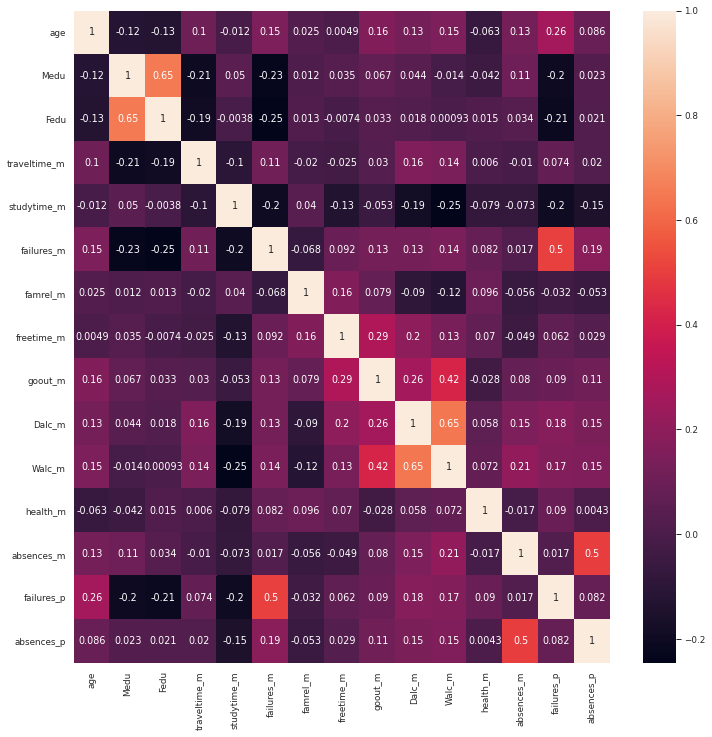

In [9]:
up_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=.1).astype('bool'))
to_drop = [column for column in up_tri.columns if any(up_tri[column] > 0.93)]

_, ax=plt.subplots(figsize=(12,12))

(sns.heatmap(full_df.drop(columns=to_drop)
             .drop(columns=grade_cols)
             .corr(),
            annot=True)
)

In [10]:
print(to_drop)
full_df.drop(columns=to_drop,inplace=True)

['traveltime_p', 'studytime_p', 'famrel_p', 'freetime_p', 'goout_p', 'Dalc_p', 'Walc_p', 'health_p']


<ipython-input-433-03a795d9e811>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  full_df[grade_cols].hist(ax=ax)


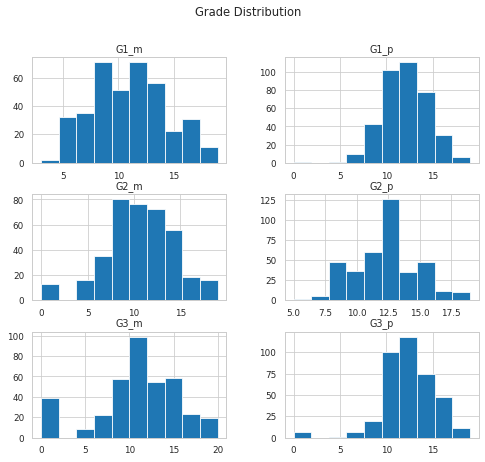

In [433]:
_, ax=plt.subplots(figsize=(8,7))
full_df[grade_cols].hist(ax=ax)
_.suptitle('Grade Distribution');

### For the categorical Variable, we will use the mean grade in math

<ipython-input-11-d4b3eb5207ea>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  full_df[['mean_m','mean_p']].hist(ax=ax);


Text(0.5, 0.98, 'Mean grade Distribution')

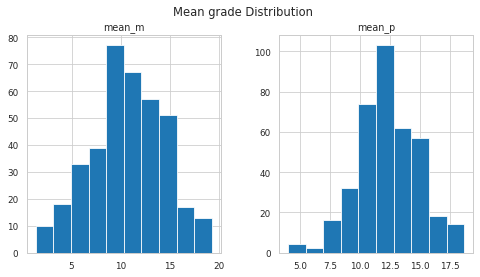

In [11]:
full_df['mean_m'] = full_df[['G1_m','G2_m','G3_m']].mean(axis=1)
full_df['over_avg_m'] = (full_df['mean_m'] > 10).astype('float32')

full_df['mean_p'] = full_df[['G1_p','G2_p','G3_p']].mean(axis=1)
full_df['over_avg_p'] = (full_df['mean_p'] > 10).astype('float32')

_, ax=plt.subplots(figsize=(8,4))
full_df[['mean_m','mean_p']].hist(ax=ax);
_.suptitle('Mean grade Distribution')

In [75]:
grade_cols = ['G1','G2','G3']
math_df['mean_grade'] = math_df[grade_cols].mean(1)

mg_top_25 = math_df[grade_cols].quantile(0.75).mean()
mg_lower_25 = math_df[grade_cols].quantile(0.25).mean()

top_25_df = math_df.loc[math_df['mean_grade'] >= mg_top_25]
low_25_df = math_df.loc[math_df['mean_grade'] <= mg_lower_25]

In [76]:
top_stats=(top_25_df.mean()
                   .to_frame()
                   .reset_index()
                   .rename(columns={'index':'column',0:'mean'})
                  )

bottom_stats=( low_25_df.mean()
                   .to_frame()
                   .reset_index()
                   .rename(columns={'index':'column',0:'mean'})
                  )

In [79]:
diff_df = top_stats.merge(bottom_stats, on='column',suffixes=['_top','_bottom']).set_index('column')
diff_df.drop(grade_cols,inplace=True)
diff_df.drop(['age','mean_grade'],inplace=True)

,mean_top,mean_bottom
column,,
Medu,3.135922,2.475728
Fedu,2.757282,2.242718
traveltime,1.271845,1.524272
studytime,2.194175,1.902913
failures,0.067961,0.825243
famrel,4.009709,3.864078
freetime,3.262136,3.252427
goout,2.893204,3.388350
Dalc,1.262136,1.495146


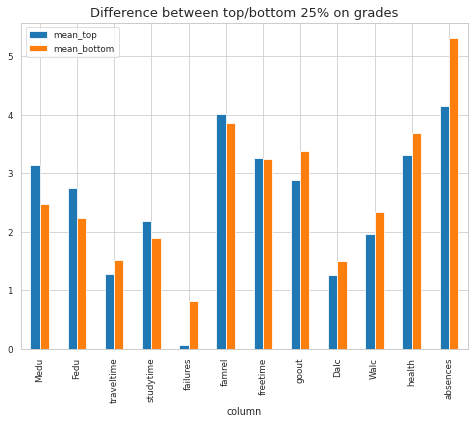

In [81]:
fig, ax = plt.subplots(figsize=(8,6))
diff_df.drop(['age','mean_grade']).plot(kind='bar',ax=ax)
ax.set_title('Difference between top/bottom 25% on grades',size=13);

### Feature Engineering

In [16]:
full_df.drop(columns= ['G1_m', 'G2_m','G3_m','mean_m'],inplace=True)
full_df.drop(columns= ['mean_p','G1_p', 'G2_p','G3_p'],inplace=True)

In [17]:
object_cols = full_df.select_dtypes(['object']).columns
full_df[object_cols] = full_df[object_cols].apply(lambda x: x.astype('category'))
full_df.dtypes[:4]

school     category
sex        category
age           int64
address    category
dtype: object

In [18]:
dep_var = 'over_avg_m'

def cont_cat_split(df, max_card=20, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        
        # mod to detect ProductSize type properly
        if (df[label].dtype.name == 'category'):
            cat_names.append(label)
            continue

        if (np.issubdtype(df[label].dtype, np.integer) and
            df[label].unique().shape[0] > max_card or
            np.issubdtype(df[label].dtype, np.floating)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [19]:
# preparing TabularPandas
procs = [Categorify, FillMissing]
cont,cat=cont_cat_split(full_df,1,dep_var)
splitter = ShuffleSplit(n_splits=1,test_size=0.3)
train_idx, test_idx = next(splitter.split(full_df.index))

In [20]:
split = (list(train_idx), list(test_idx))
len(split)

2

In [21]:
to = TabularPandas(full_df, procs, cat,
                   cont, y_names=dep_var,
                   splits=split,y_block=CategoryBlock())

In [22]:
len(to.train),len(to.valid)

(267, 115)

### Saving TabularPandas for later use

In [499]:
save_pickle(path/'student_tab.pkl',to)

### Loading TabularPandas file

In [352]:
to = load_pickle(path/'student_tab.pkl')

In [23]:
train_x,train_y = to.train.xs,to.train.y
valid_x,valid_y = to.valid.xs,to.valid.y

## Modelling
---

### Decision Trees

In [24]:
dt = DecisionTreeClassifier(max_leaf_nodes=4)
dt = dt.fit(train_x,train_y)
dt_preds=dt.predict(valid_x)

Number of leaves: 4 



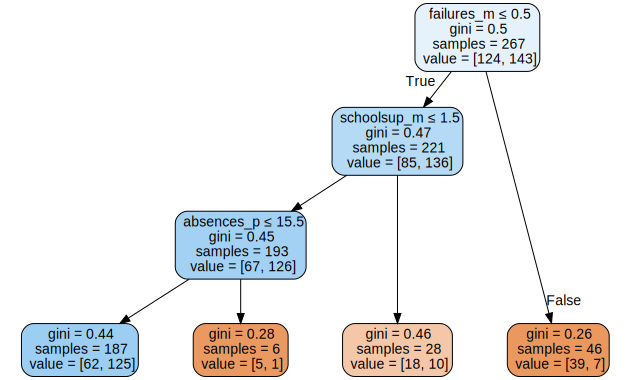

In [83]:
print(f'Number of leaves: {dt.get_n_leaves()} \n')
draw = draw_tree(dt, train_x, size=10, leaves_parallel=True, precision=2)
draw

In [ ]:
draw.

In [26]:
def get_metrics(true, preds):
    
    df = ( pd.Series({
    'f1':f1_score(true,preds),
    'recall':recall_score(true, preds),
    'acc':accuracy_score(true, preds),
    'prec':precision_score(true, preds)})
          .to_frame()
         )
    
    df.reset_index(inplace=True)
    df.rename(columns={'index':'metrics',
                      0:'value'},inplace=True)
    return df

In [27]:
dt_metrics = get_metrics(valid_y, dt_preds)
dt_metrics

,metrics,value
0,f1,0.797203
1,recall,0.919355
2,acc,0.747826
3,prec,0.703704


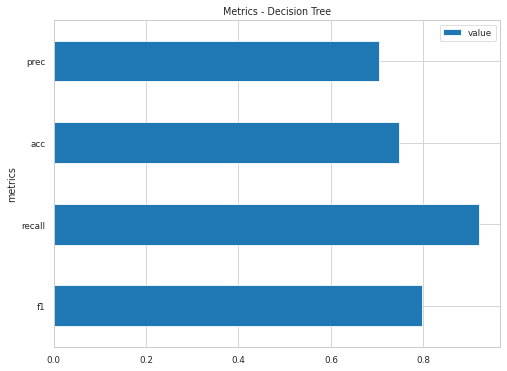

In [28]:
_,ax=plt.subplots(figsize=(8,6))
dt_metrics.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - Decision Tree');

In [29]:
param_grid = {'max_depth':range(1, 20),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(train_x, train_y)
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(3, 1)

In [30]:
gs_dt_preds = GR.predict(valid_x)
gs_dt_metrics = get_metrics(valid_y, gs_dt_preds)
gs_dt_metrics

,metrics,value
0,f1,0.764331
1,recall,0.967742
2,acc,0.678261
3,prec,0.631579


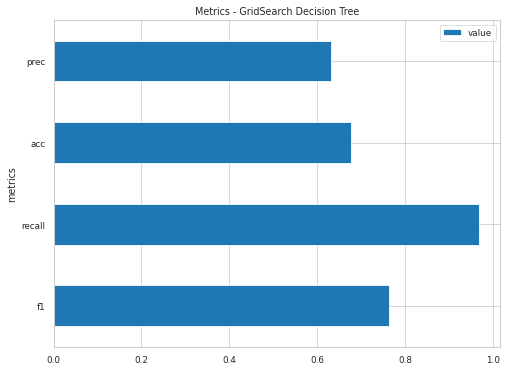

In [31]:
_,ax=plt.subplots(figsize=(8,6))
gs_dt_metrics.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - GridSearch Decision Tree');

Number of leaves: 2 



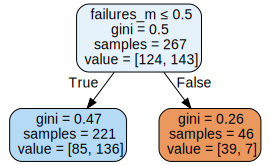

In [32]:
print(f'Number of leaves: {GR.best_estimator_.get_n_leaves()} \n')
draw_tree(GR.best_estimator_, train_x, size=1e5, leaves_parallel=True, precision=2)

### Random Forests

In [33]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=40,
        max_samples=len(train_x), max_features=0.4,
        min_samples_leaf=8, oob_score=True)
rf_fitted = rf.fit(train_x, train_y)
rf_preds=rf.predict(valid_x)

In [34]:
rf_metrics = get_metrics(valid_y,rf_preds)
rf_metrics

,metrics,value
0,f1,0.800000
1,recall,0.870968
2,acc,0.765217
3,prec,0.739726


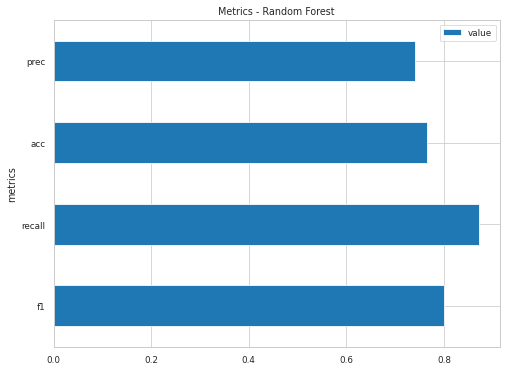

In [35]:
_,ax=plt.subplots(figsize=(8,6))
rf_metrics.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - Random Forest');

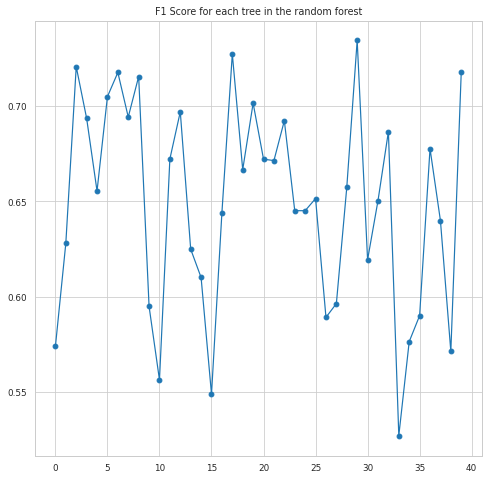

In [39]:
preds = np.stack([t.predict(valid_x) for t in rf.estimators_])

fig, ax = plt.subplots(figsize=(8,8))

ax.plot([f1_score(valid_y, preds[i]).item() for i in range(40)],'-o')

ax.set_title('F1 Score for each tree in the random forest');

In [40]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [41]:
feature_importance_rf = rf_feat_importance(rf, train_x)

In [42]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

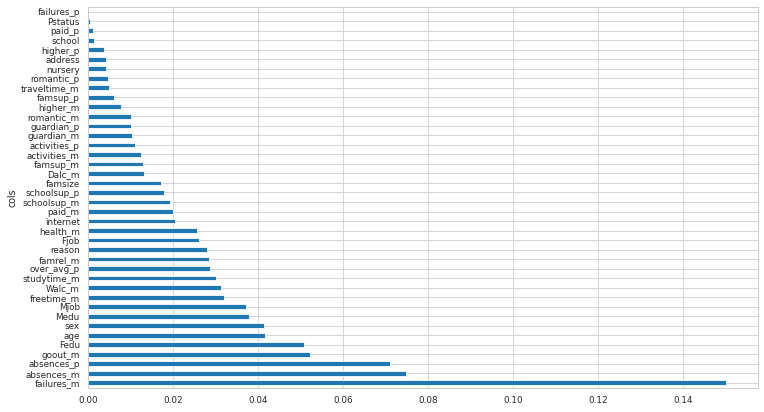

In [84]:
plot_fi(feature_importance_rf)

#### Keeping most Important

In [45]:
to_keep=feature_importance_rf.loc[feature_importance_rf['imp']>=0.03]['cols'].values
to_keep

array(['failures_m', 'absences_m', 'absences_p', 'goout_m', 'Fedu', 'age', 'sex', 'Medu', 'Mjob', 'freetime_m', 'Walc_m', 'studytime_m'], dtype=object)

In [86]:
train_x_n = train_x[to_keep]
valid_x_n = valid_x[to_keep]
fitted_mi=rf.fit(train_x_n, train_y)
fitted_mi_preds = fitted_mi.predict(valid_x[to_keep])
most_important_metrics=get_metrics(valid_y,fitted_mi_preds)
most_important_metrics

,metrics,value
0,f1,0.773723
1,recall,0.854839
2,acc,0.730435
3,prec,0.706667


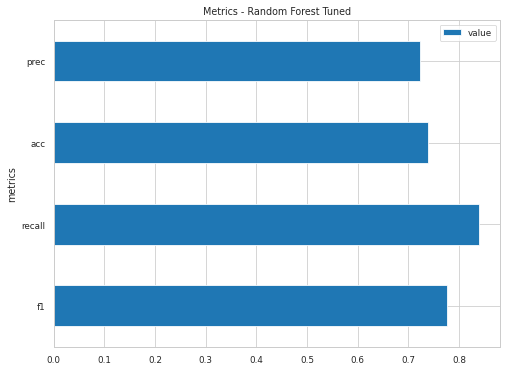

In [85]:
_,ax=plt.subplots(figsize=(8,6))
most_important_metrics.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - Random Forest Tuned');

In [47]:
rf_metrics

,metrics,value
0,f1,0.800000
1,recall,0.870968
2,acc,0.765217
3,prec,0.739726


<AxesSubplot:ylabel='cols'>

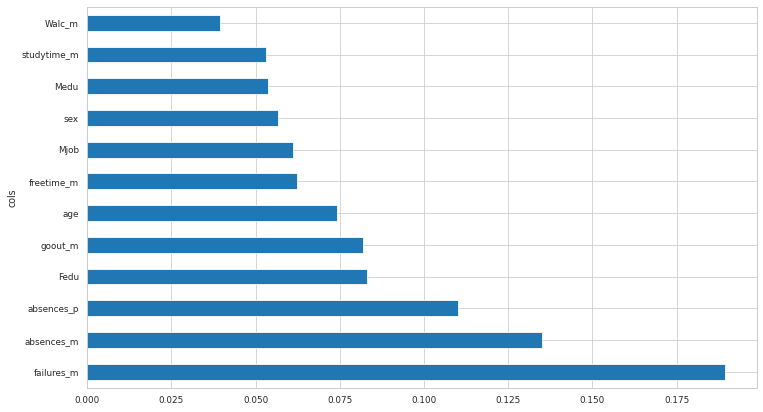

In [48]:
plot_fi(rf_feat_importance(fitted_mi,train_x_n))

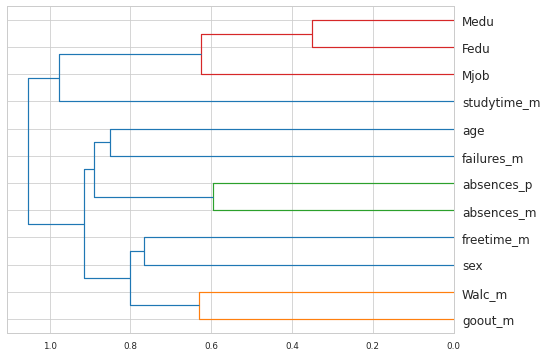

In [56]:
cluster_columns(train_x_n,figsize=(8,6))

### SVM

In [486]:
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

kwargs = {'kernel': 'rbf'}
svc = SVC(**kwargs)
nystroem = Nystroem(**kwargs)
sgd = SGDClassifier()

In [487]:
fitted = svc.fit(train_x, train_y)

In [488]:
svc_preds = fitted.predict(valid_x)

In [478]:
# with nystroem
nystro_x = nystroem.fit_transform(train_x)
nystro_vx = nystroem.transform(valid_x)

In [480]:
nystrofit = svc.fit(nystro_x, train_y)
nystropreds = nystrofit.predict(nystro_vx)

In [481]:
sgd_fitted = sgd.fit(train_x, train_y)
sgd_preds = sgd_fitted.predict(valid_x)

In [492]:
svc_metrics = get_metrics(valid_y,svc_preds)
nystro_preds=get_metrics(valid_y,nystropreds)
sgd_metrics=get_metrics(valid_y,sgd_preds)

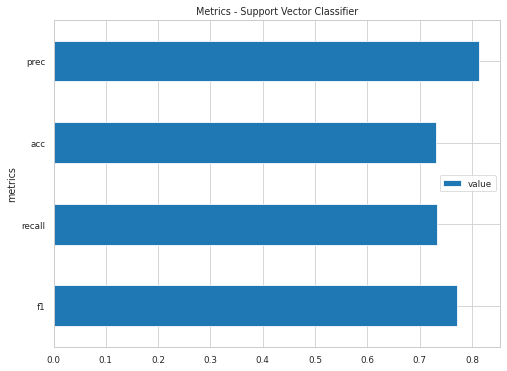

In [495]:
_,ax=plt.subplots(figsize=(8,6))
svc_metrics.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - Support Vector Classifier');

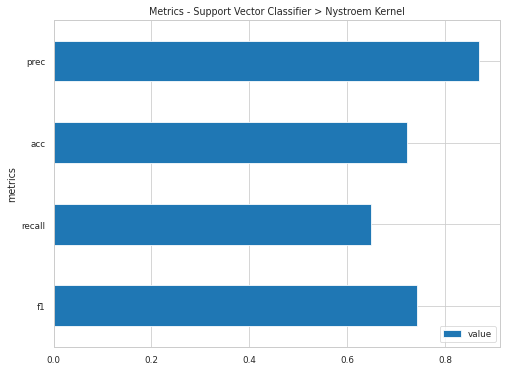

In [497]:
_,ax=plt.subplots(figsize=(8,6))
nystro_preds.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - Support Vector Classifier > Nystroem Kernel');

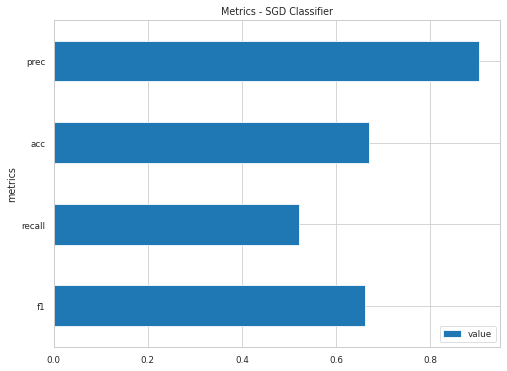

In [498]:
_,ax=plt.subplots(figsize=(8,6))
sgd_metrics.plot('metrics','value',
                   kind='barh',ax=ax);
ax.set_title('Metrics - SGD Classifier');

### Ensemble

In [101]:
row = valid_x_n.iloc[:5]

In [102]:
# !pip install treeinterpreter
from waterfall_chart import plot as waterfall

In [103]:
from treeinterpreter import treeinterpreter

In [104]:
prediction,bias,contributions = treeinterpreter.predict(fitted_mi, row.values)

In [114]:
contributions[0].sum()

6.938893903907228e-18